In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers, callbacks
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Resizing, BatchNormalization, Lambda, Activation \
    ,Resizing, Rescaling, Dropout, InputLayer, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import os
import glob
import random
import shutil
import matplotlib.pyplot as plt

In [2]:
IMAGES_DIR = os.path.join(".", "images_labeled")

In [3]:
ground_truth = pd.read_csv("./GroundTruth.csv")
ground_truth.iloc[:, 1:].sum()

MEL      1113.0
NV       6705.0
BCC       514.0
AKIEC     327.0
BKL      1099.0
DF        115.0
VASC      142.0
dtype: float64

In [4]:
import random
p = [x for x in range(10)]
q = random.sample(p, 3)
print(p)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
os.chdir(IMAGES_DIR)
if os.path.isdir("train") is False:
    os.mkdir("train")
    os.mkdir("valid")
    os.mkdir("test")
    
    for col in ground_truth.iloc[:, 1:].columns:
        print(col)
        os.chdir(col)
        n_img = ground_truth.iloc[:, 1:].sum()[col]
        test_size = int(np.ceil(n_img * .1))
        train_val_size = int(np.floor(n_img * .9))
        train_size = int(np.ceil(train_val_size * .8))
        val_size = int(train_val_size - train_size)

        os.mkdir(os.path.join("..", "train", col))
        os.mkdir(os.path.join("..", "valid", col))
        os.mkdir(os.path.join("..", "test", col))

        idx = np.arange(n_img, dtype=np.int32)
        np.random.shuffle(idx)

        train_file = np.array(glob.glob(col+'*'))[idx[:train_size]]
        val_file = np.array(glob.glob(col+'*'))[idx[train_size:train_val_size]]
        test_file = np.array(glob.glob(col+'*'))[idx[-test_size:]]

        for img in train_file:
            shutil.move(img, os.path.join("..", "train", col))
        for img in val_file:
            shutil.move(img, os.path.join("..", "valid", col))
        for img in test_file:
            shutil.move(img, os.path.join("..", "test", col))

        os.chdir("..")
os.chdir("..")


In [6]:
TRAIN_PATH = os.path.join(IMAGES_DIR, "train")
VAL_PATH = os.path.join(IMAGES_DIR, "valid")
TEST_PATH = os.path.join(IMAGES_DIR, "test")

In [7]:
CLASSES = list(ground_truth.iloc[:, 1:].columns)
CLASSES

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [8]:
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    label_mode='categorical',
    batch_size=32,
    image_size=(224,224)
)

val_ds = image_dataset_from_directory(
    VAL_PATH,
    label_mode='categorical',
    batch_size=32,
    image_size=(224,224)
)

Found 7212 files belonging to 7 classes.
Found 1798 files belonging to 7 classes.


In [9]:
train_ds.class_names

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [10]:
total_img = len(ground_truth)
cl_weight = {}
for i, cl in enumerate(train_ds.class_names):
    cl_weight[i] = total_img / (ground_truth.iloc[:, 1:].sum()[cl] * 7)
cl_weight


{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [11]:
from functools import partial

Conv2D3Kernel = partial(Conv2D, kernel_size=3, strides=1, padding='same', use_bias=False)

In [12]:
def ResBlock(inputs, filters, strides=1):
    input_main = Conv2D3Kernel(filters, strides=strides)(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = Conv2D3Kernel(filters)(input_main)
    input_main = BatchNormalization()(input_main)

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(input_main + input_skip)
    

In [13]:
def DoubleResBlock(inputs, filters, strides=1):
    input_main = Conv2D3Kernel(filters, strides=strides)(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = Conv2D3Kernel(filters)(input_main)
    input_main = BatchNormalization()(input_main)

    input_main_2 = Conv2D3Kernel(filters, strides=strides)(inputs)
    input_main_2 = BatchNormalization()(input_main)
    input_main_2 = Activation(activation=keras.activations.relu)(input_main)
    input_main_2 = Conv2D3Kernel(filters)(input_main)
    input_main_2 = BatchNormalization()(input_main)

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(input_main + input_main_2 + input_skip)

def ResNextBlock(inputs, filters, strides=1):
    input_main = []
    for i in range(8):
        temp_main = Conv2D3Kernel(14, kernel_size=1)(inputs)
        temp_main = BatchNormalization()(temp_main)
        temp_main = Conv2D3Kernel(14, strides=strides)(temp_main)
        temp_main = BatchNormalization()(temp_main)
        temp_main = Activation(activation=keras.activations.relu)(temp_main)
        temp_main = Conv2D3Kernel(filters, kernel_size=1)(temp_main)
        temp_main = BatchNormalization()(temp_main)
        input_main.append(temp_main)
    
    total_main = input_main[0]
    for item in input_main[1:]:
        total_main = total_main + item
    
    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(total_main + input_skip)

In [14]:
def SeResBlock(inputs, filters, strides=1):
    input_main = Conv2D3Kernel(filters, strides=strides)(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = Conv2D3Kernel(filters)(input_main)
    input_main = BatchNormalization()(input_main)

    scaling = GlobalAveragePooling2D()(input_main)
    scaling = Dense(filters/2, activation="relu", kernel_initializer="he_normal")(scaling)
    scaling = BatchNormalization()(scaling)
    scaling = Dense(filters, activation="sigmoid")(scaling)

    input_main = layers.Multiply()([input_main, scaling])

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(input_main + input_skip)

def SeResNextBlock(inputs, filters, strides=1):
    input_main = []
    for i in range(8):
        temp_main = Conv2D3Kernel(12, kernel_size=1)(inputs)
        temp_main = BatchNormalization()(temp_main)
        temp_main = Conv2D3Kernel(12, strides=strides)(temp_main)
        temp_main = BatchNormalization()(temp_main)
        temp_main = Activation(activation=keras.activations.relu)(temp_main)
        temp_main = Conv2D3Kernel(filters, kernel_size=1)(temp_main)
        temp_main = BatchNormalization()(temp_main)
        input_main.append(temp_main)
    
    total_main = input_main[0]
    for item in input_main[1:]:
        total_main = total_main + item

    scaling = GlobalAveragePooling2D()(total_main)
    scaling = Dense(filters/4, activation="relu", kernel_initializer="he_normal")(scaling)
    scaling = BatchNormalization()(scaling)
    scaling = Dense(filters, activation="sigmoid")(scaling)

    total_main = layers.Multiply()([total_main, scaling])
    
    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(total_main + input_skip)

In [15]:
def InvBottleResBlock(inputs, filters, strides=1, ex_r=6):
    input_main = Conv2D3Kernel(filters*ex_r, kernel_size=1, strides=strides)(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = layers.DepthwiseConv2D(kernel_size=3, padding="same", use_bias=False)(input_main)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = Conv2D3Kernel(filters, kernel_size=1)(input_main)

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    elif inputs.shape[3] != filters:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return input_main + input_skip

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.Input(shape=(224,224,3)),
  Lambda(lambda x : tf.image.random_flip_left_right(x)),
  Lambda(lambda x : tf.image.random_flip_up_down(x)),
  Lambda(lambda x : tf.image.random_brightness(x, 0.1)),
  Lambda(lambda x : tf.image.random_contrast(x, 0, 0.1)),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.15),
])

In [17]:
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [18]:
t = tf.constant([1,1,0], tf.float32)
t - 1e-7

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 9.999999e-01,  9.999999e-01, -1.000000e-07], dtype=float32)>

In [19]:
class OrionLoss(keras.losses.Loss):
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold
    
    def call(self, y_true, y_pred):
        inv_y_true = tf.cast((y_true == 0) & (y_pred > self.threshold), tf.float32)
        cce = tf.cast(y_true * tf.math.log(y_pred + 1e-7), tf.float32)
        res = inv_y_true * y_pred
        res_entropy = res * tf.math.log(1 - res - 1e-7)
        return tf.reduce_sum(-cce-res_entropy, axis=1)

In [20]:
a = np.array([[0, 1, 0], [1,0,0]])
b = np.array([[0, .1, 0], [.3,.7,0]])
OrionLoss().call(a,b)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025842, 2.0467536], dtype=float32)>

In [21]:
print(tf.math.log(.9999999))

tf.Tensor(-1.192093e-07, shape=(), dtype=float32)


In [22]:
'''input_layer = layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=(7, 7), strides=2, padding="valid", activation="relu")(rescaling)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D(pool_size=3)(conv_1)
maxpool_1 = tf.nn.local_response_normalization(maxpool_1)
resb_1 = ResNextBlock(maxpool_1, 32, 2)
resb_1 = ResNextBlock(resb_1, 32)
resb_1 = ResNextBlock(resb_1, 32)
resb_1 = ResNextBlock(resb_1, 64, 2)
resb_1 = ResNextBlock(resb_1, 64)
resb_1 = ResNextBlock(resb_1, 64)

global_aux = GlobalAveragePooling2D()(resb_1)
flatten_aux = Flatten()(global_aux)
output_aux = Dense(7, activation="softmax", name="aux_output")(flatten_aux) 

resb_1 = ResNextBlock(resb_1, 96, 2)
resb_1 = ResNextBlock(resb_1, 96)
resb_1 = ResNextBlock(resb_1, 128, 2)
resb_1 = ResNextBlock(resb_1, 128)
global_avg = GlobalAveragePooling2D()(resb_1)
flatten = Flatten()(global_avg)
output = Dense(7, activation="softmax", name="output")(flatten)
model = Model(inputs=[input_layer], outputs=[output, output_aux])

model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=3e-3), 
    loss="categorical_crossentropy", 
    loss_weights=[0.85, 0.15], 
    metrics=['accuracy']
    )'''

'input_layer = layers.Input(shape=(224,224,3))\nrescaling = Rescaling(1./255)(input_layer)\nconv_1 = Conv2D(filters=32, kernel_size=(7, 7), strides=2, padding="valid", activation="relu")(rescaling)\nconv_1 = BatchNormalization()(conv_1)\nmaxpool_1 = MaxPooling2D(pool_size=3)(conv_1)\nmaxpool_1 = tf.nn.local_response_normalization(maxpool_1)\nresb_1 = ResNextBlock(maxpool_1, 32, 2)\nresb_1 = ResNextBlock(resb_1, 32)\nresb_1 = ResNextBlock(resb_1, 32)\nresb_1 = ResNextBlock(resb_1, 64, 2)\nresb_1 = ResNextBlock(resb_1, 64)\nresb_1 = ResNextBlock(resb_1, 64)\n\nglobal_aux = GlobalAveragePooling2D()(resb_1)\nflatten_aux = Flatten()(global_aux)\noutput_aux = Dense(7, activation="softmax", name="aux_output")(flatten_aux) \n\nresb_1 = ResNextBlock(resb_1, 96, 2)\nresb_1 = ResNextBlock(resb_1, 96)\nresb_1 = ResNextBlock(resb_1, 128, 2)\nresb_1 = ResNextBlock(resb_1, 128)\nglobal_avg = GlobalAveragePooling2D()(resb_1)\nflatten = Flatten()(global_avg)\noutput = Dense(7, activation="softmax", nam

In [23]:
'''input_layer = layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=(7, 7), strides=2, padding="valid", activation="relu")(rescaling)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D(pool_size=3)(conv_1)
maxpool_1 = tf.nn.local_response_normalization(maxpool_1, depth_radius=2)
resb_1 = SeResNextBlock(maxpool_1, 32, 2)
resb_1 = SeResNextBlock(resb_1, 32)
resb_1 = SeResNextBlock(resb_1, 32)
resb_1 = SeResNextBlock(resb_1, 64, 2)
resb_1 = SeResNextBlock(resb_1, 64)
resb_1 = SeResNextBlock(resb_1, 64)

global_aux = GlobalAveragePooling2D()(resb_1)
flatten_aux = Flatten()(global_aux)
output_aux = Dense(7, activation="softmax", name="aux_output")(flatten_aux) 
conv_skip = Conv2D(filters=128, kernel_size=1, strides=4, padding="same", activation="relu")(resb_1)
conv_skip = tf.nn.local_response_normalization(conv_skip)

resb_1 = SeResNextBlock(resb_1, 96, 2)
resb_1 = SeResNextBlock(resb_1, 96)
resb_1 = SeResNextBlock(resb_1, 128, 2)
resb_1 = SeResNextBlock(resb_1, 128)
global_avg = GlobalAveragePooling2D()(resb_1 + conv_skip)
flatten = Flatten()(global_avg)

output = Dense(7, activation="softmax", name="output")(flatten)
model = Model(inputs=[input_layer], outputs=[output, output_aux])

model.compile(
    optimizer=keras.optimizers.Nadam(), 
    loss="categorical_crossentropy", 
    loss_weights=[0.85, 0.15], 
    metrics=['accuracy']
    )'''

'input_layer = layers.Input(shape=(224,224,3))\nrescaling = Rescaling(1./255)(input_layer)\nconv_1 = Conv2D(filters=32, kernel_size=(7, 7), strides=2, padding="valid", activation="relu")(rescaling)\nconv_1 = BatchNormalization()(conv_1)\nmaxpool_1 = MaxPooling2D(pool_size=3)(conv_1)\nmaxpool_1 = tf.nn.local_response_normalization(maxpool_1, depth_radius=2)\nresb_1 = SeResNextBlock(maxpool_1, 32, 2)\nresb_1 = SeResNextBlock(resb_1, 32)\nresb_1 = SeResNextBlock(resb_1, 32)\nresb_1 = SeResNextBlock(resb_1, 64, 2)\nresb_1 = SeResNextBlock(resb_1, 64)\nresb_1 = SeResNextBlock(resb_1, 64)\n\nglobal_aux = GlobalAveragePooling2D()(resb_1)\nflatten_aux = Flatten()(global_aux)\noutput_aux = Dense(7, activation="softmax", name="aux_output")(flatten_aux) \nconv_skip = Conv2D(filters=128, kernel_size=1, strides=4, padding="same", activation="relu")(resb_1)\nconv_skip = tf.nn.local_response_normalization(conv_skip)\n\nresb_1 = SeResNextBlock(resb_1, 96, 2)\nresb_1 = SeResNextBlock(resb_1, 96)\nresb_

In [24]:
input_layer = layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=(7, 7), strides=2, padding="valid", activation="relu")(rescaling)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D(pool_size=3)(conv_1)
maxpool_1 = tf.nn.local_response_normalization(maxpool_1)
resb_1 = SeResBlock(maxpool_1, 32)
resb_1 = SeResBlock(resb_1, 32)
resb_1 = SeResBlock(resb_1, 64, 2)
resb_1 = SeResBlock(resb_1, 64)
resb_1 = SeResBlock(resb_1, 96, 2)
resb_1 = SeResBlock(resb_1, 96)
resb_1 = SeResBlock(resb_1, 128, 2)
resb_1 = SeResBlock(resb_1, 128)
global_avg = GlobalAveragePooling2D()(resb_1)
flatten = Flatten()(global_avg)
output = Dense(7, activation="softmax", name="output")(flatten)
model = Model(inputs=[input_layer], outputs=[output])

model.compile(
    optimizer=keras.optimizers.Nadam(), 
    loss=OrionLoss(), 
    metrics=['accuracy', keras.metrics.CategoricalCrossentropy()]
    )

In [25]:
input_layer = layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=5, strides=2, activation="relu", padding="same")(rescaling)
conv_1 = BatchNormalization()(conv_1)
conv_1 = tf.nn.local_response_normalization(conv_1)
invbot = InvBottleResBlock(conv_1, 16, ex_r=1)
invbot = InvBottleResBlock(invbot, 24, 2)
invbot = InvBottleResBlock(invbot, 24)
invbot = InvBottleResBlock(invbot, 32, 2)
invbot = InvBottleResBlock(invbot, 32)
invbot = InvBottleResBlock(invbot, 64, 2)
invbot = InvBottleResBlock(invbot, 64)
invbot = InvBottleResBlock(invbot, 64)
invbot = InvBottleResBlock(invbot, 96)
invbot = InvBottleResBlock(invbot, 96)
invbot = InvBottleResBlock(invbot, 128, 2)
invbot = InvBottleResBlock(invbot, 128)
invbot = InvBottleResBlock(invbot, 200)
conv_2 = Conv2D(filters=360, kernel_size=1, activation="relu")(invbot)
conv_2 = BatchNormalization()(conv_2)
global_avg = GlobalAveragePooling2D()(conv_2)
flatten = Flatten()(global_avg)
output = Dense(7, activation="softmax", name="output")(flatten)
model = Model(inputs=[input_layer], outputs=[output])

model.compile(
    optimizer=keras.optimizers.Nadam(), 
    loss=OrionLoss(), 
    metrics=['accuracy', keras.metrics.CategoricalCrossentropy()]
    )

In [26]:
from keras.models import load_model

model = load_model("skin_cancer_invbneckres_V2_oloss.h5", compile=False)
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=1e-5), 
    loss=OrionLoss(), 
    metrics=['accuracy', keras.metrics.CategoricalCrossentropy()]
    )

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 112, 112, 32  2432        ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [28]:
lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.3, patience=2, min_lr=1e-7)

In [29]:
history = model.fit(aug_ds, validation_data=val_ds, epochs=10, class_weight=cl_weight, callbacks=[lr_scheduler])

Epoch 1/10
226/226 [==============================] - 560s 2s/step - loss: 1.7196 - accuracy: 0.4379 - categorical_crossentropy: 1.6164 - val_loss: 1.3884 - val_accuracy: 0.4783 - val_categorical_crossentropy: 1.3868 - lr: 1.0000e-05
Epoch 2/10
226/226 [==============================] - 504s 2s/step - loss: 1.7081 - accuracy: 0.4311 - categorical_crossentropy: 1.6118 - val_loss: 1.3847 - val_accuracy: 0.4839 - val_categorical_crossentropy: 1.3832 - lr: 1.0000e-05
Epoch 3/10
226/226 [==============================] - 509s 2s/step - loss: 1.7004 - accuracy: 0.4316 - categorical_crossentropy: 1.6153 - val_loss: 1.3897 - val_accuracy: 0.4816 - val_categorical_crossentropy: 1.3882 - lr: 1.0000e-05
Epoch 4/10
226/226 [==============================] - 499s 2s/step - loss: 1.7009 - accuracy: 0.4314 - categorical_crossentropy: 1.6175 - val_loss: 1.3846 - val_accuracy: 0.4750 - val_categorical_crossentropy: 1.3831 - lr: 1.0000e-05
Epoch 5/10
226/226 [==============================] - 509s 2s/st

In [30]:
history2 = model.fit(aug_ds, validation_data=val_ds, epochs=10, class_weight=cl_weight, callbacks=[lr_scheduler])

Epoch 1/10
 13/226 [>.............................] - ETA: 7:38 - loss: 1.7320 - accuracy: 0.3726 - categorical_crossentropy: 1.7057

KeyboardInterrupt: 

In [ ]:
history3 = model.fit(aug_ds, validation_data=val_ds, epochs=2, class_weight=cl_weight, callbacks=[lr_scheduler])

Epoch 1/2
289/289 [==============================] - 285s 984ms/step - loss: 1.7385 - output_loss: 1.7402 - aux_output_loss: 1.7289 - output_accuracy: 0.4163 - aux_output_accuracy: 0.4124 - val_loss: 1.4503 - val_output_loss: 1.4568 - val_aux_output_loss: 1.4137 - val_output_accuracy: 0.4794 - val_aux_output_accuracy: 0.4833 - lr: 8.1000e-05
Epoch 2/2
289/289 [==============================] - 292s 1s/step - loss: 1.7344 - output_loss: 1.7371 - aux_output_loss: 1.7189 - output_accuracy: 0.4169 - aux_output_accuracy: 0.4128 - val_loss: 1.4550 - val_output_loss: 1.4607 - val_aux_output_loss: 1.4224 - val_output_accuracy: 0.4778 - val_aux_output_accuracy: 0.4811 - lr: 8.1000e-05


In [ ]:
history4 = model.fit(aug_ds, validation_data=val_ds, epochs=8, class_weight=cl_weight, callbacks=[lr_scheduler])

Epoch 1/8


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history).head()

,loss,output_loss,aux_output_loss,output_accuracy,aux_output_accuracy,val_loss,val_output_loss,val_aux_output_loss,val_output_accuracy,val_aux_output_accuracy,lr
0,2.063800,2.013666,2.347891,0.329389,0.296702,2.015761,2.054921,1.793857,0.147621,0.305469,0.001
1,2.008118,1.969917,2.224591,0.341961,0.323029,1.941378,1.926498,2.025700,0.215207,0.158293,0.001
2,1.947276,1.919954,2.102097,0.334418,0.321254,1.608758,1.651806,1.364819,0.364606,0.523344,0.001
3,1.884935,1.857890,2.038188,0.315338,0.311492,1.868521,1.866071,1.882403,0.305024,0.200534,0.001
4,1.849411,1.826946,1.976704,0.348173,0.328058,1.735968,1.757071,1.616382,0.114273,0.600711,0.001


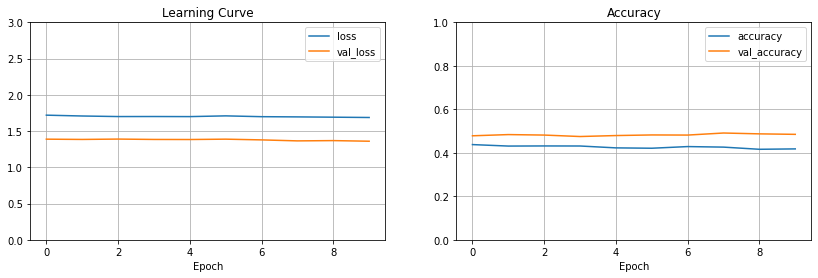

In [40]:


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epoch")
axes[0].grid(True)
axes[0].set_ylim([0,3])

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].set_ylim([0, 1])

plt.show()

(0.0, 1.0)

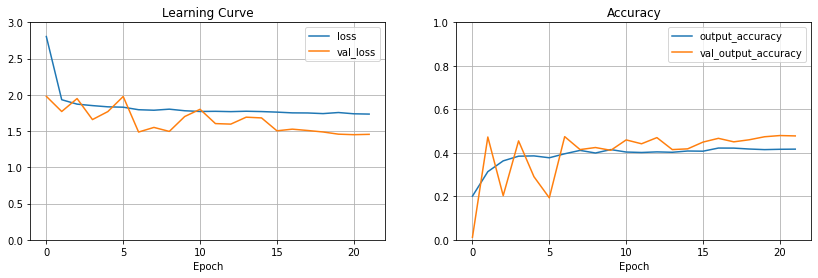

In [ ]:
h1 = pd.DataFrame(history.history)
h2 = pd.DataFrame(history2.history, index=[x for x in range(10, 20)])
h3 = pd.DataFrame(history3.history, index=[20,21])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
pd.concat([h1,h2,h3])[["loss", 'val_loss']].plot(ax=axes[0])
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epoch")
axes[0].grid(True)
axes[0].set_ylim([0,3])

pd.concat([h1,h2,h3])[['output_accuracy', 'val_output_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].set_ylim([0, 1])

(0.0, 1.0)

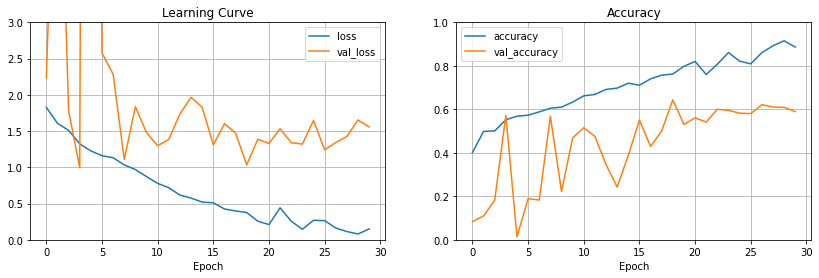

In [ ]:
h1 = pd.DataFrame(history.history)
h2 = pd.DataFrame(history2.history, index=[20, 21])
h3 = pd.DataFrame(history3.history, index=[22, 23])
h4 = pd.DataFrame(history4.history, index=[24, 25,26,27,28,29])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
pd.concat([h1,h2,h3, h4])[["loss", 'val_loss']].plot(ax=axes[0])
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epoch")
axes[0].grid(True)
axes[0].set_ylim([0,3])

pd.concat([h1,h2,h3, h4])[["accuracy", 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].set_ylim([0, 1])

In [ ]:
pd.concat([h1,h2,h3]).tail()

,loss,accuracy,val_loss,val_accuracy
19,0.256554,0.797811,1.388403,0.530458
20,0.209908,0.820293,1.329341,0.560694
21,0.441261,0.760243,1.531931,0.541574
22,0.256901,0.807425,1.340227,0.600267
23,0.145071,0.861115,1.320583,0.595376


In [39]:
model.save("skin_cancer_invbneckres_V2_oloss.h5")

In [31]:
test_ds = image_dataset_from_directory(
    TEST_PATH,
    label_mode='categorical',
    batch_size=25,
    image_size=(224,224),
    shuffle=False
)

Found 1005 files belonging to 7 classes.


In [32]:
pred = model.predict(test_ds)
pred

41/41 [==============================] - 17s 378ms/step


array([[0.12714906, 0.15202476, 0.19610554, ..., 0.31304407, 0.12395776,
        0.03819217],
       [0.14407364, 0.15401831, 0.11805757, ..., 0.15961245, 0.13044348,
        0.1325588 ],
       [0.11653626, 0.41474602, 0.07209107, ..., 0.14626569, 0.1969184 ,
        0.02455945],
       ...,
       [0.10038791, 0.15664771, 0.18614158, ..., 0.2692056 , 0.1444072 ,
        0.06487006],
       [0.0310589 , 0.08431543, 0.27656174, ..., 0.227659  , 0.2715016 ,
        0.03736356],
       [0.19505902, 0.19282949, 0.13219115, ..., 0.13305444, 0.04636529,
        0.14887594]], dtype=float32)

In [33]:
#pred = pred[1]

In [34]:
y_true = []
for X, y in test_ds:
    for d in y:
        y_true.append(d.numpy())
y_true = np.array(y_true)

In [35]:
y_true_a = np.argmax(y_true, axis=1)
y_pred_a = np.argmax(pred, axis=1)

In [36]:
y_pred_a

array([4, 3, 1, ..., 4, 2, 0], dtype=int64)

[]

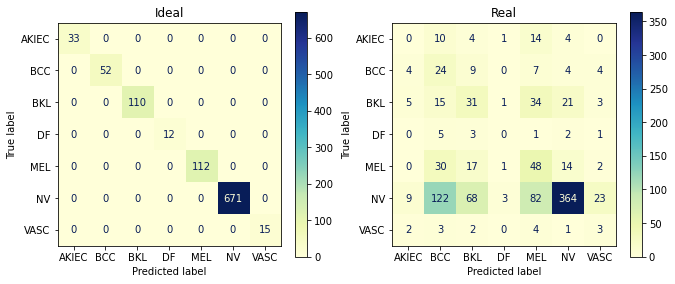

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf = confusion_matrix(y_true_a, y_pred_a)
ideal = confusion_matrix(y_true_a, y_true_a)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(11, 4.5)
ConfusionMatrixDisplay(ideal, display_labels=train_ds.class_names).plot(cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Ideal")
ConfusionMatrixDisplay(cf, display_labels=train_ds.class_names).plot(cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Real")
plt.plot()

In [38]:
from sklearn.metrics import f1_score, accuracy_score

print(accuracy_score(y_true_a, y_pred_a))
f1_score(y_true_a, y_pred_a, average="weighted")

0.46766169154228854


0.5241459545758865